In [ ]:
import glob
import os
from datetime import date, datetime
from importlib import reload

import geopandas as gpd
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from matplotlib import colors
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.patches import Patch
from rasterio import features
from rasterio.plot import reshape_as_image
from scipy import stats
from scipy.ndimage import generic_filter
from skimage import exposure  # for brightness/contrast correction
from sklearn.ensemble import RandomForestClassifier
from spectral.io import envi

import project_config
from project_config import get_config
from src import pipeline

reload(project_config)

cfg = get_config()
paths = cfg.paths

classified_folder = cfg.paths.classified
smoothed_stack_all_timestamps_file_path = cfg.paths.get_path('smoothed_stack_all_timestamps_file_path')
jungle_to_mine_change_tif_file_path = cfg.paths.get_path('jungle_to_mine_change_tif_file_path')
luc_analysis_folder = cfg.paths.luc_analysis

### Build stack

In [ ]:
def extract_and_smooth(files, smoothing = True):
    """ Extracts classification data, builds stack, applies temporal smoothing
    Takes >30mins to run"""
    # ---------------------------------
    # 1. Input setup
    # ---------------------------------
        # ---------------------------------
    # 2. Read and stack rasters (classifications)
    # ---------------------------------
    stack = []
    meta = None
    for f in files:
        with rasterio.open(f) as src:
            data = src.read(1)
            stack.append(data)
            if meta is None:
                meta = src.meta

    stack = np.stack(stack, axis=0)  # shape: (time, H, W)
    H, W = stack.shape[1:]

    ### Temporal smoothing
    if smoothing:
        for y in range(H):
            for x in range(W):
                s = stack[:,y,x]
                ## check if water
                non_cloud_vals = s[s>0]
                if (non_cloud_vals == 3).mean() > 0.5:
                    s[True] = 3
                else:
                    s[s==3] = 0

                for n in np.arange(1,len(s)-1):
                    before_n = s[:n]
                    after_n = s[n+1:]

                    try:
                        last_val = before_n[before_n > 0][-1]
                        next_val = after_n[after_n > 0][0]
                        if (last_val == next_val) & (last_val != s[n]):
                            s[n] = last_val
                    except:
                        continue
    return stack, meta

In [27]:
run_smoothing = False

smoothed_path = smoothed_stack_all_timestamps_file_path

files = sorted(glob.glob(os.path.join(classified_folder, "*_classified.tif")))
filenames = [os.path.basename(f) for f in files]

print("Found years:", filenames)

if run_smoothing:
    stack, meta = extract_and_smooth(files, smoothing=True)
    np.save(smoothed_path, stack)

else:
    stack = np.load(smoothed_path)

    with rasterio.open(files[0]) as f:
        meta = f.meta

print("Stack shape:", stack.shape)

Found years: ['LC08_L2SP_109060_20131017_20200912_02_T1_classified.tif', 'LC08_L2SP_109060_20160127_20200907_02_T1_classified.tif', 'LC08_L2SP_109060_20160212_20200907_02_T1_classified.tif', 'LC08_L2SP_109060_20160502_20200907_02_T1_classified.tif', 'LC08_L2SP_109060_20160603_20200907_02_T1_classified.tif', 'LC08_L2SP_109060_20161110_20200905_02_T1_classified.tif', 'LC08_L2SP_109060_20170505_20200904_02_T1_classified.tif', 'LC08_L2SP_109060_20171012_20200903_02_T1_classified.tif', 'LC08_L2SP_109060_20171129_20200902_02_T1_classified.tif', 'LC08_L2SP_109060_20171231_20200902_02_T1_classified.tif', 'LC08_L2SP_109060_20180508_20200901_02_T1_classified.tif', 'LC08_L2SP_109060_20180609_20200831_02_T1_classified.tif', 'LC08_L2SP_109060_20180727_20200831_02_T1_classified.tif', 'LC08_L2SP_109060_20180913_20200830_02_T1_classified.tif', 'LC08_L2SP_109060_20181031_20200830_02_T1_classified.tif', 'LC08_L2SP_109060_20190204_20200829_02_T1_classified.tif', 'LC08_L2SP_109060_20190324_20200829_02_T1_

### Map classification images

In [ ]:
# ---------------------------------
# 3. Plot each year: image + classification
# ---------------------------------
H, W = stack.shape[1:]

# Define classes and colors
classes = {
    0: ("Cloud", "lightgrey"),
    1: ("Jungle", "forestgreen"),
    2: ("Mining", "orange"),
    3: ("Ocean", "skyblue"),
    254: ("No data (red)", "red"),
    255: ("No data (black)", "black")
}

# Sort them by code
vals, info = zip(*sorted(classes.items()))
names, cols = zip(*info)

# Make colormap + matching normalizer
cmap = colors.ListedColormap(cols)
norm = colors.BoundaryNorm([v - 0.5 for v in vals] + [vals[-1] + 0.5], len(vals))

n_years = len(filenames)

plot = False

if plot:
    fig, axes = plt.subplots(n_years, 2, figsize=(8, 4 * n_years))

    for i, year in enumerate(filenames):
        if i > 1:
            continue
        # Load the corresponding original stacked image
        img_path = f"data/stacked/{year[:-15]}/{year[:-15]}"
        with rasterio.open(img_path) as src:
            img = src.read([4, 3, 2])  # RGB bands (assumed first 3)
            rgb = reshape_as_image(img.astype(float))
        
        # ---------------------------------
        # 3a. Brightness/contrast correction
        # ---------------------------------
        # Stretch intensity to 2–98% range to normalize contrast
        rgb_corrected = exposure.rescale_intensity(rgb, in_range='image', out_range=(0, 1))
        rgb_corrected = exposure.equalize_adapthist(rgb_corrected, clip_limit=0.06)  # optional adaptive contrast

        # Increase middle exposure
        rgb_corrected = exposure.adjust_gamma(rgb_corrected, gamma=0.9)

        #rgb_corrected = rgb
        # ---------------------------------
        # 3b. Get classification map
        # ---------------------------------
        cls = stack[i]

        # ---------------------------------
        # 3c. Plot side by side
        # ---------------------------------
        ax_img, ax_cls = axes[i] if n_years > 1 else (axes[0], axes[1])

        ax_img.imshow(rgb_corrected)
        ax_img.set_title(f"{year} - RGB")
        ax_img.axis("off")

        im = ax_cls.imshow(cls, cmap=cmap, norm=norm)
        ax_cls.set_title(f"{year} - Classified")
        ax_cls.axis("off")

    plt.tight_layout()
    plt.show()

### Calculate initial and final states, and year of transition

In [ ]:
rewrite_files = True

# ---------------------------------
# 3. Compute initial, final, and change years
# ---------------------------------
initial_state = np.full((H, W), -1, dtype=np.int16)
final_state = np.full((H, W), -1, dtype=np.int16)
change_year = np.full((H, W), -1, dtype=np.int32)

dates = [pipeline.extract_scene_date(y) for y in filenames]

for y in range(H):
    pix_seq = stack[:, y, :]
    ocean_mask = np.any(pix_seq == 3, axis=0)
    for x in range(W):
        if ocean_mask[x]:
            continue

        seq = pix_seq[:, x]
        noncloud_idx = np.where(seq != 0)[0]
        if len(noncloud_idx) == 0:
            continue

        first_i = noncloud_idx[0]
        last_i = noncloud_idx[-1]
        initial = seq[first_i]
        final = seq[last_i]

        initial_state[y, x] = initial
        final_state[y, x] = final

        if ((initial != 1) | (final != 2)):  # only track jungle origins
            continue
            
        jungle_array = np.where(seq == 2)[0]

        if len(jungle_array) == 0:
            continue

        change_year[y, x] = int(dates[jungle_array[0]])
        continue 

        #below code is redundant, as long as above code works
        
        jungle_to_mine = np.where((seq[:-1] == 1) & (seq[1:] == 2))[0]
        if len(jungle_to_mine) == 0:
            continue

        change_i = jungle_to_mine[0] + 1
        #reverted = np.any(seq[change_i:] == 1) #instead of checking if it has reverted back to mining, add check above for final = mining (2) 
        #if not reverted:
        change_year[y, x] = years[change_i]

# ---------------------------------
# 4. Save 3-band output
# ---------------------------------

if rewrite_files:
    if meta is None:
        with rasterio.open(files[0]) as f:
            meta = f.meta
    out_meta = meta.copy()
    
    out_path = jungle_to_mine_change_tif_file_path
    out_meta.update(dtype=rasterio.int32, count=3)
    with rasterio.open(out_path, "w", **out_meta) as dst:
        dst.write(initial_state, 1)
        dst.write(final_state, 2)
        dst.write(change_year, 3)

    print("✅ Saved:", out_path)


✅ Saved: output/classified/jungle_to_mine_change.tif


### Plot changes

c:\Users\anson\Documents\University\2\GEOM90005 Remote Sensing\Project\wedabaywatch\src\pipeline.py:525: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
c:\Users\anson\Documents\University\2\GEOM90005 Remote Sensing\Project\wedabaywatch\src\pipeline.py:526: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
c:\Users\anson\Documents\University\2\GEOM90005 Remote Sensing\Project\wedabaywatch\src\pipeline.py:525: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
c:\Users\anson\Documents\University\2\GEOM90005 Remote Sensing\Project\wedabaywatch\src\pipeline.py:526: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


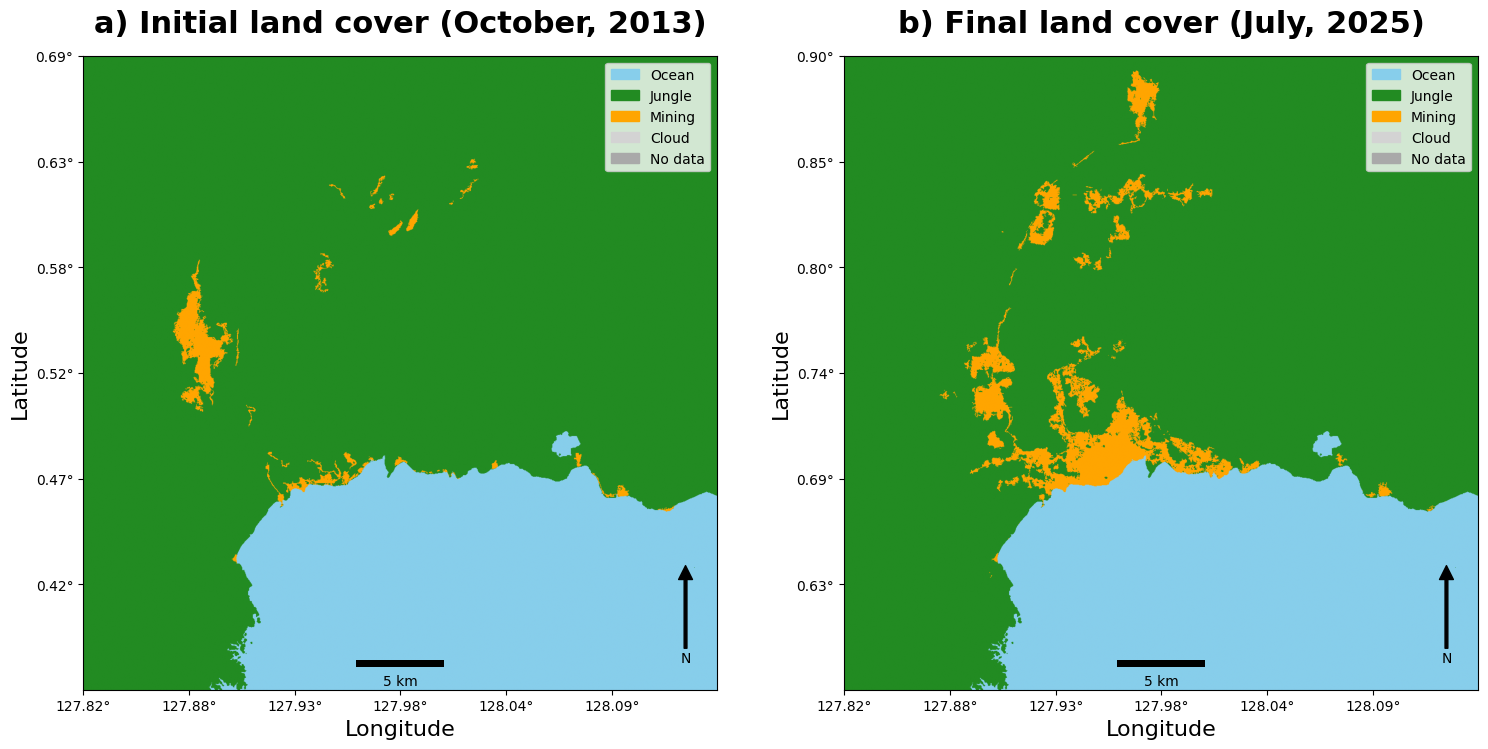

In [ ]:
reload(pipeline)

x_bounds = (0, 1200)
y_bounds = (800, 2000)

# -------------------------------
# 1. Load raster (clip first 600 rows)
# -------------------------------
path = jungle_to_mine_change_tif_file_path

with rasterio.open(path) as src:
    initial_state = src.read(1)[y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]
    final_state = src.read(2)[y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]
    change_year = src.read(3)[y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]

# -------------------------------
# 2. Class colors and labels
# -------------------------------
# Define classes and colors
classes = {
    3: ("Cloud", "lightgrey"),
    1: ("Jungle", "forestgreen"),
    2: ("Mining", "orange"),
    0: ("Ocean", "skyblue"),
    254: ("No data", "darkgrey"),
}

# Sort them by code
vals, info = zip(*sorted(classes.items()))
names, cols = zip(*info)

# Make colormap + matching normalizer
cmap = colors.ListedColormap(cols)
norm = colors.BoundaryNorm([v - 0.5 for v in vals] + [vals[-1] + 0.5], len(vals))

# ✅ Correct legend patches
legend_patches = [Patch(color=c, label=l) for c, l in zip(cols, names)]

# -------------------------------
# 3. Change-year color setup
# -------------------------------
masked_years = np.where((change_year >= 20160101) , change_year, np.nan)
masked_years = masked_years // 10000
# Define only the years you want
years = np.array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025])

# Create discrete colormap and normalization
cmap_year = plt.cm.plasma(np.linspace(0, 1, len(years)))
cmap_year = ListedColormap(cmap_year)
boundaries = np.concatenate(([years[0] - 0.5], years + 0.5))
norm_year = BoundaryNorm(boundaries, cmap_year.N)

# -------------------------------
# 4. Plot setup
# -------------------------------
# # Calculate scale bar (e.g., 300 m)
pixel_size = 30  # meters per pixel

# scalebar_length_m = 5000
# scalebar_length_px = scalebar_length_m / pixel_size

# def add_scalebar(ax, length_px, label="5km", loc='lower left', pad=-20):
#     """Add a simple horizontal scale bar."""
#     x0 = pad
#     y0 = ax.get_ylim()[0] + pad
#     ax.hlines(y=y0, xmin=x0+30, xmax=x0 + 30 + length_px, colors='black', linewidth=3)
#     ax.text(x0 + 15 + length_px / 2, y0 + pad * 0.5, label, ha='center', va='bottom', color='black', fontsize=10)


fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# --- Initial state
im1 = axes[0].imshow(initial_state, cmap=cmap, norm=norm)
axes[0].set_title("a) Initial land cover (October, 2013)", fontsize=22, fontweight='bold', pad=17)
axes[0].legend(handles=legend_patches, loc="upper right", frameon=True)
# add_scalebar(axes[0], scalebar_length_px)
pipeline.PlotUtils.add_north_arrow(axes[0])
pipeline.PlotUtils.add_scalebar(axes[0], pixel_size=pixel_size)
pipeline.PlotUtils.add_geographic_labels(axes[0], raster_path=path, x_bounds=x_bounds, y_bounds=y_bounds)

# --- Final state
im2 = axes[1].imshow(final_state, cmap=cmap, norm=norm)
axes[1].set_title("b) Final land cover (July, 2025)", fontsize=22, fontweight='bold', pad=17)
axes[1].legend(handles=legend_patches, loc="upper right", frameon=True)

pipeline.PlotUtils.add_north_arrow(axes[1])
pipeline.PlotUtils.add_scalebar(axes[1], pixel_size=pixel_size)
pipeline.PlotUtils.add_geographic_labels(axes[1], raster_path=path, x_bounds=x_bounds, y_bounds=y_bounds)

# # --- Jungle→Mining year (overlay on dull background)
# # Background (final state, slightly transparent grayscale)
# axes[2].imshow(np.where(final_state == 254, 3, final_state)[:,110:-110], cmap='gray', alpha=0.3)
# pipeline.PlotUtils.add_north_arrow(axes[2])

# # Overlay transition years
# im3 = axes[2].imshow(masked_years[:,110:-110], cmap=cmap_year, norm=norm_year)

# axes[2].set_title("Year of Land Clearing")
# cbar = plt.colorbar(im3, ax=axes[2], boundaries=years - 0.5, ticks=years)
# cbar.set_label("Transition Year")


# axes[2].set_xticks([])
# axes[2].set_yticks([])
# add_scalebar(axes[2], scalebar_length_px)

# plt.tight_layout()
# plt.savefig("output/plots/initial_final_yearofclearing.svg")


c:\Users\anson\Documents\University\2\GEOM90005 Remote Sensing\Project\wedabaywatch\src\pipeline.py:521: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(round(x_labels, 2))
c:\Users\anson\Documents\University\2\GEOM90005 Remote Sensing\Project\wedabaywatch\src\pipeline.py:522: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(round(y_labels, 2))


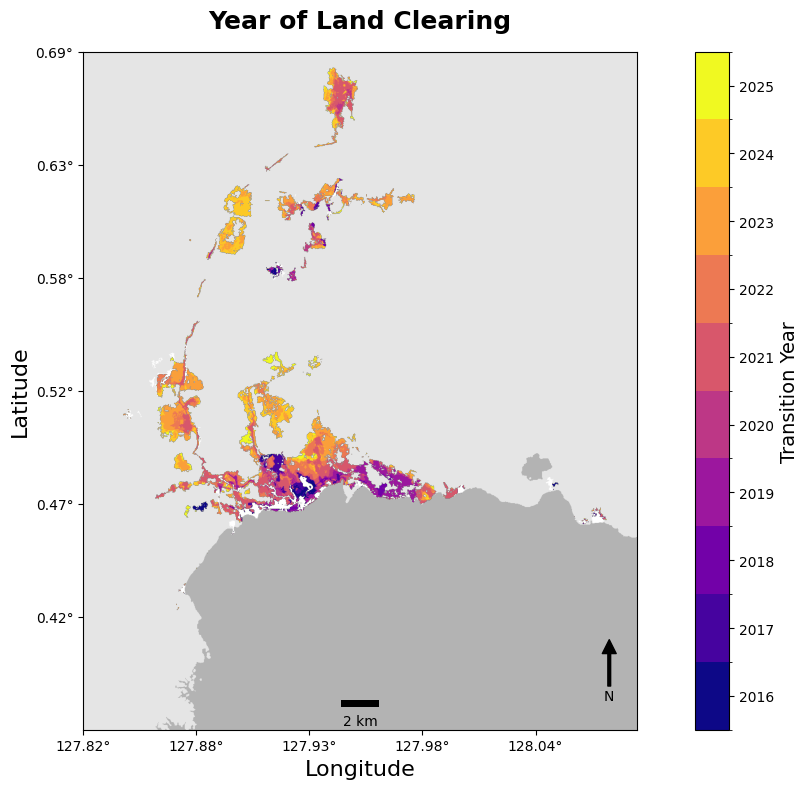

In [121]:
# --- Jungle→Mining year (overlay on dull background)
# Background (final state, slightly transparent grayscale)
fig, ax = plt.subplots(figsize=(12, 8))

ax.imshow(np.where(final_state == 254, 3, final_state)[:,110:-110], cmap='gray', alpha=0.3)

# Overlay transition years
ax.imshow(masked_years[:,110:-110], cmap=cmap_year, norm=norm_year)

ax.set_title("Year of Land Clearing", fontsize=18, fontweight='bold', pad=17)
cbar = plt.colorbar(ax.get_images()[1], ax=ax, boundaries=years - 0.5, ticks=years)
cbar.set_label("Transition Year", fontsize=14)

pipeline.PlotUtils.add_north_arrow(ax)
pipeline.PlotUtils.add_scalebar(ax, pixel_size=pixel_size)
pipeline.PlotUtils.add_geographic_labels(ax, raster_path=path, x_bounds=x_bounds, y_bounds=y_bounds)

plt.tight_layout()
plt.savefig("output/plots/initial_final_yearofclearing_changes.svg")

### Count Area

In [42]:
def get_non_cloud_state(y,x,yr):
    pix_seq = stack[:, y, x]
    if yr == 0:
        return initial_state[y, x]
    else:
        current_pixel = stack[yr, y, x]
        if ((current_pixel < 1) | (current_pixel > 10)): # 0 (cloud) or 254 (no data)
            return get_non_cloud_state(y,x,yr-1)
        else:
            return current_pixel

In [ ]:
with rasterio.open(path) as src:
    initial_state = src.read(1)[y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]
    final_state = src.read(2)[y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]
    change_year = src.read(3)[y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]
    
## Rebuild stack without any cloud

dates_dt = [datetime.strptime(dt, '%Y%m%d') for dt in dates]

sorted_indices = np.argsort(dates_dt)

stack_sorted_clipped = stack[sorted_indices,y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]

stack_no_cloud = stack_sorted_clipped.copy()


"""
for yr in range(len(stack)):
    print(yr)
    for y in np.arange(0,y_bounds[1]-y_bounds[0]):
        for x in np.arange(0,x_bounds[1]-x_bounds[0]):
            current_pixel = get_non_cloud_state(y,x,yr)
            stack_no_cloud[yr, y, x] = current_pixel
"""


for y in np.arange(0,y_bounds[1]-y_bounds[0]):
    for x in np.arange(0,x_bounds[1]-x_bounds[0]):
        pix_seq = stack_sorted_clipped[:, y, x]
        for yr in range(len(stack)):
            if yr == 0:
                no_cloud_val = initial_state[y, x]
            else:
                current_pixel = stack_sorted_clipped[yr, y, x]
                if ((current_pixel >= 1) | (current_pixel <=3)): # 0 (cloud) or 254 (no data)
                    no_cloud_val = current_pixel
            stack_no_cloud[yr, y, x] = no_cloud_val


In [ ]:
cleared = []
revegetated = []
ever_cleared = []

for yr in range(len(stack_no_cloud)):
    #print('total cleared',(stack_no_cloud[yr] == 2).sum())
    cleared.append((stack_no_cloud[yr] == 2).sum())

#    if yr > 0:
#        print('newly cleared',((stack_no_cloud[yr] == 2) & (stack_no_cloud[yr-1] == 1)).sum())
#        print('newly revegetated',((stack_no_cloud[yr] == 1) & (stack_no_cloud[yr-1] == 2)).sum())
    ever_cleared_num = ((np.any(stack_no_cloud[:(yr+1)] == 2, axis=0))).sum()
    #reveg_num = ((np.any(stack_no_cloud[:yr] == 1, axis=0)) & (np.any(stack_no_cloud[:yr] == 2, axis=0))).sum()
    #print('revegetated',reveg_num)
    ever_cleared.append(ever_cleared_num)



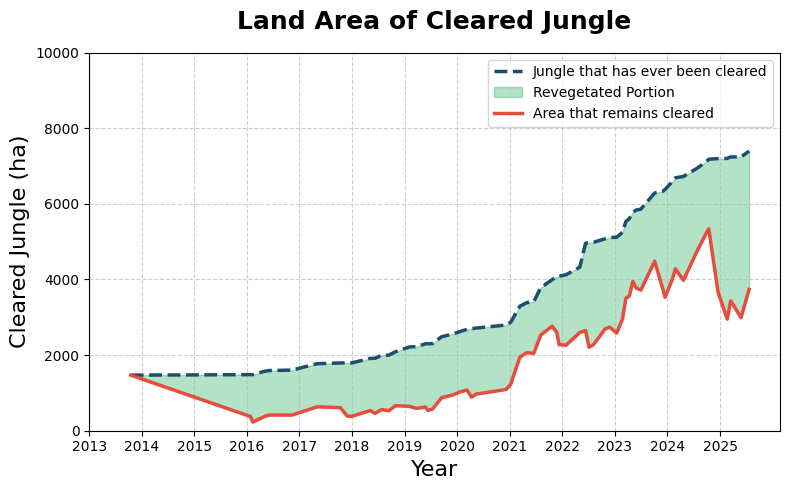

In [ ]:
# convert to ha
np_cleared = np.array(cleared) * (30 * 30) / 10000 # 30*30 for m^2, then /10000 for ha
np_ever_cleared = np.array(ever_cleared) * (30 * 30) / 10000 # 30*30 for m^2, then /10000 for ha


# Restrict to range 2016–2023 and drop 2018 if missing
years = [date(y,1,1) for y in range(2013, 2026)]
dates = [y.split("_")[3] for y in filenames]

dates_dt = [datetime.strptime(dt, '%Y%m%d') for dt in dates]

sorted_indices = np.argsort(dates_dt)

dates_dt.sort()
# np_cleared = np_cleared[sorted_indices]
# np_ever_cleared = np_ever_cleared[sorted_indices]
# np_revegetated = np_revegetated[sorted_indices]

# Create a nice-looking plot
plt.figure(figsize=(8, 5))
plt.plot(
    dates_dt, np_ever_cleared,
    linestyle='--', linewidth=2.5, markersize=6,
    color='#1B4F72', label='Jungle that has ever been cleared'
)

plt.fill_between(
    dates_dt, np_cleared, np_ever_cleared,
    color='#27AE60', alpha=0.35, label='Revegetated Portion'
)

plt.plot(
    dates_dt, np_cleared,
    linestyle='-', linewidth=2.5, markersize=6,
    color='#E74C3C', label='Area that remains cleared'
)

#plt.plot(dates, np_revegetated, marker='o', linewidth=2.5, markersize=8, color='#2E86AB', label = 'Revegetated')

# Style it nicely
plt.title("Land Area of Cleared Jungle", fontsize=18, fontweight='bold', pad=17)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Cleared Jungle (ha)", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(years, labels = range(2013, 2026))
plt.ylim([0,10000])
plt.tight_layout()
plt.legend()

plt.savefig("output/plots/cleared_land_linegraph.svg")


### Save LUC stats to file

In [60]:
df = pd.DataFrame({'cleared_forest': np_cleared, 'ever_cleared_forest': np_ever_cleared, 'date': dates_dt})

df.to_csv(luc_analysis_folder + '/luc_timeseries.csv')

np_ever_cleared

array([1469.61, 1482.75, 1482.75, 1570.68, 1591.29, 1603.44, 1773.09,
       1792.26, 1794.15, 1794.42, 1911.87, 1914.66, 1997.01, 1997.01,
       2089.35, 2215.98, 2224.17, 2298.87, 2300.76, 2302.83, 2485.8 ,
       2559.15, 2624.49, 2680.2 , 2695.95, 2714.76, 2795.4 , 2869.29,
       3295.08, 3386.88, 3413.16, 3781.62, 3996.09, 4073.31, 4087.89,
       4124.61, 4327.2 , 4959.81, 4967.28, 4983.57, 5078.43, 5109.66,
       5116.14, 5245.74, 5530.59, 5610.24, 5776.74, 5836.95, 5860.53,
       6286.77, 6330.6 , 6380.19, 6576.48, 6689.34, 6725.7 , 6944.67,
       7122.69, 7179.93, 7197.48, 7201.89, 7241.13, 7241.13, 7396.29])

### Animated GIF

In [18]:
classes = {
    3: ("Ocean", "#2878B5"),      # deep but natural blue
    0: ("Cloud", "#D9D9D9"),      # soft neutral grey
    1: ("Jungle", "#228B22"),     # rich green with good luminance
    2: ("Mining", "#E89C31"),     # warm amber/orange (less harsh)
    -1: ("No data", "#2878B5")    # very dark grey (less stark than black)
}


In [ ]:
# Extract and apply colormap
classes = {
    0: ("Cloud", "lightgrey"),
    1: ("Jungle", "forestgreen"),
    2: ("Mining", "orange"),
    3: ("Ocean", "skyblue"),
    254: ("No data", "darkgrey"),
}

# Sort them by code
vals, info = zip(*sorted(classes.items()))
names, cols = zip(*info)

# Make colormap + matching normalizer
cmap = ListedColormap(cols)
norm = BoundaryNorm([v - 0.5 for v in vals] + [vals[-1] + 0.5], len(vals))


fig, ax = plt.subplots()
ax.axis('off')

dates_dt = [datetime.strptime(dt, '%Y%m%d') for dt in dates]
sorted_indices = np.argsort(dates_dt)
years = [dt.year for dt in dates_dt]


def update(frame):
    im_index = sorted_indices[frame]
    im = ax.imshow(stack[im_index], cmap=cmap, norm=norm, animated=True)
    im.set_array(stack[im_index])
    ax.set_title(f"{years[im_index]}")
    return [im]

ani = animation.FuncAnimation(
    fig, update, frames=len(stack),
    interval=15000,  # milliseconds per frame
    blit=True, repeat=False
)

# Save as GIF
ani.save("stack_animation_v3.gif", writer='pillow', fps=3)
plt.close()
print("✅ Saved as stack_animation_v3.gif")


✅ Saved as stack_animation_v3.gif
